# Импорт библиотек

In [14]:
from random import uniform
from random import random
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.figsize'] = 8, 8    # Стандартные размеры графиков
plt.rcParams['axes.grid'] = True           # Сетка графика
plt.pink()                                 # Цветовая схема при раскраске

<Figure size 800x800 with 0 Axes>

# Тестовые функции для оптимизации

In [15]:
@njit
def rastrigin(x: np.ndarray):  # функция Растригина от -5.12 до 5.12
    a = 10
    result = 0
    n = x.size
    for i in range(n):
        result += x[i] ** 2 - a * np.cos(2 * np.pi * x[i])

    return a * n + result

@njit
def sphere(x: np.ndarray):   # функция Сферы
    result = 0
    n = x.size
    for i in range(n):
        result += x[i] ** 2
    return result

@njit
def rozenbroke(x: np.ndarray):  # Функция Розенброка, минимум в точке f(1;1) = 0
    result = 0
    n = x.size
    for i in range(n - 1):
        result += (100 * x[i+1] - x[i] ** 2) ** 2 + (x[i] - 1) ** 2
    return result

# Реализация метода роя частиц на Python с использованием numba

In [35]:
@njit
def main(v_max: float, dimension: int, f):
    px_list: np.ndarray
    py_list: np.ndarray
    best_solution: np.ndarray
    best_coord: np.ndarray

    # dimension = 2  # размерность
    r1 = np.random.rand(dimension - 1)
    r2 = np.random.rand(dimension - 1)
    weight = 3.4
    p_global_best = 1000.0
    p_best_coordinates = np.zeros(dimension - 1)

    for j in range(50):
        coordinates = np.random.uniform(-5.12, 5.12, dimension - 1)
        c1 = random()
        c2 = random()
        p_coordinates_now = np.copy(coordinates)
        p_coordinates = np.copy(coordinates)
        p = f(coordinates)
        array_of_speed = np.zeros((400, dimension - 1))

        if p_global_best > p:
            p_best_coordinates = p_coordinates
            p_global_best = p

        for k in range(dimension - 1):
            array_of_speed[0][k] = uniform(-1 * v_max, v_max)

        for i in range(1, len(array_of_speed)):
            array_of_speed[i] = array_of_speed[i - 1] * weight + \
                                c1 * r1 * (p_best_coordinates - p_coordinates_now) + \
                                c2 * r2 * (p_best_coordinates - p_coordinates_now)

            for k in range(dimension - 1):
                if array_of_speed[i][k] > 0:
                    array_of_speed[i][k] = min(array_of_speed[i][k], v_max)
                else:
                    array_of_speed[i][k] = max(array_of_speed[i][k], v_max)

            p_coordinates_now = p_coordinates_now + array_of_speed[i]

            if p > f(p_coordinates_now):
                p = f(p_coordinates_now)
                p_coordinates = p_coordinates_now

        if j == 0:
            px_list = np.copy(coordinates)
            py_list = np.array([p])
        else:
            px_list = np.append(px_list, coordinates)
            py_list = np.append(py_list, p)

        if p_global_best > p:
            p_best_coordinates = p_coordinates
            p_global_best = p

        if j == 0:
            best_solution = np.array([p_global_best])
            best_coord = np.copy(p_best_coordinates)
        else:
            best_solution = np.append(best_solution, p_global_best)
            best_coord = np.append(best_coord, p_best_coordinates)
    print("global_best:", p_global_best, "coordinates:", p_best_coordinates)
    # print("Размерности совпадают: ", px_list.shape == py_list.shape)
    return [px_list, py_list], [best_coord, best_solution]

In [36]:
list_of_all = main(1.154, 2, rastrigin)
list_of_x = list_of_all[0][0]
list_of_y = list_of_all[0][1]
list_of_best_coord = list_of_all[1][0]
list_of_best_solution = list_of_all[1][1]

global_best: 0.007300502648535101 coordinates: [0.00606653]


[ 2.58170592  1.88398201  0.9060324  -3.55951746 -3.74113561 -3.21280604
 -2.45659701  2.74075174 -0.63962142  4.33137547  4.73939828  4.62878462
  2.74454284  1.2296114   3.49440583 -2.49877327 -4.71685632 -1.6622563
  5.11409546 -4.81302537 -3.99609489 -3.0270541   3.23336138 -1.7249893
  4.02949991  2.12227854 -3.2847539  -1.94539604 -4.96281513 -4.02790678
 -2.37254876  3.42173019 -3.52050613 -2.37203798  0.21598752  4.35875004
 -3.05074047  3.3062908  -4.31891491 -2.3970626   3.88756346  0.53584799
 -2.88954018 -0.08224156 -2.7955499   4.44533803 -0.42096895  2.39690661
  2.94563677 -3.14846299] 
 [24.8524152   4.13121266  2.51380237  1.73930903  3.70034728  2.55472425
  1.01659696 17.27711114 13.57328168 33.65390291 33.12752922 38.32658527
 17.16262003 10.23439161 32.20469538  1.19354846  1.66143569  9.14398626
 28.61539805  1.27898916  9.58118357  6.52424432 19.41109375 12.82147968
 16.40815761  7.31312653  1.06052562  2.58353563  4.14216874 10.44389246
  0.8153971  29.62560205 

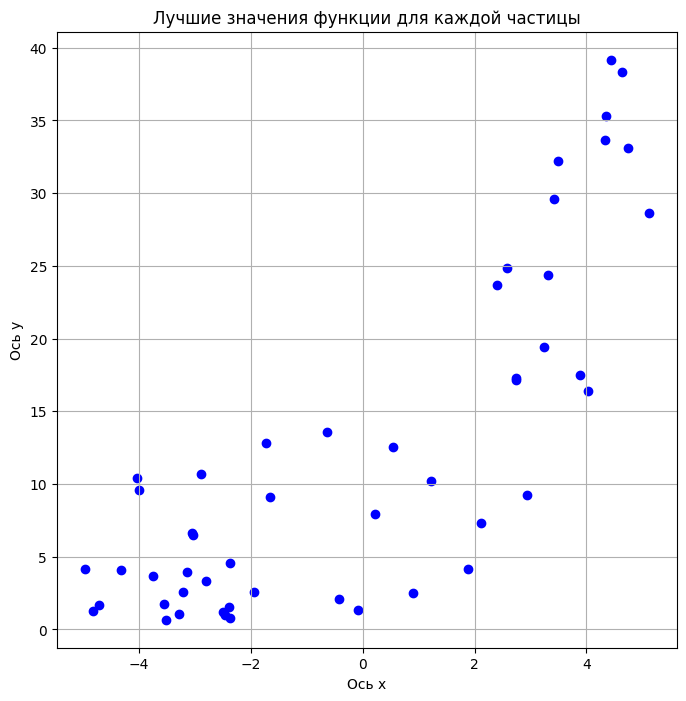

In [18]:
print(list_of_x, "\n", list_of_y)

plt.scatter(list_of_x, list_of_y, c = 'b', label = 'local min for each agent')
plt.xlabel("Ось x")
plt.ylabel("Ось y")
plt.title("Лучшие значения функции для каждой частицы")
plt.show()

[ 0.93816056  0.93816056 -0.99875909 -0.99875909 -0.99875909 -0.99875909
 -0.99875909 -0.99875909 -0.99875909 -0.99875909 -0.99875909 -0.99875909
 -0.99875909  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653
  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653
  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653
  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653
  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653
  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653  0.00606653
  0.00606653  0.00606653] 
 [1.62554648 1.62554648 0.99782367 0.99782367 0.99782367 0.99782367
 0.99782367 0.99782367 0.99782367 0.99782367 0.99782367 0.99782367
 0.99782367 0.0073005  0.0073005  0.0073005  0.0073005  0.0073005
 0.0073005  0.0073005  0.0073005  0.0073005  0.0073005  0.0073005
 0.0073005  0.0073005  0.0073005  0.0073005  0.0073005  0.0073005
 0.0073005  0.0073005  0.0073005  0.0073005  0.0073005  

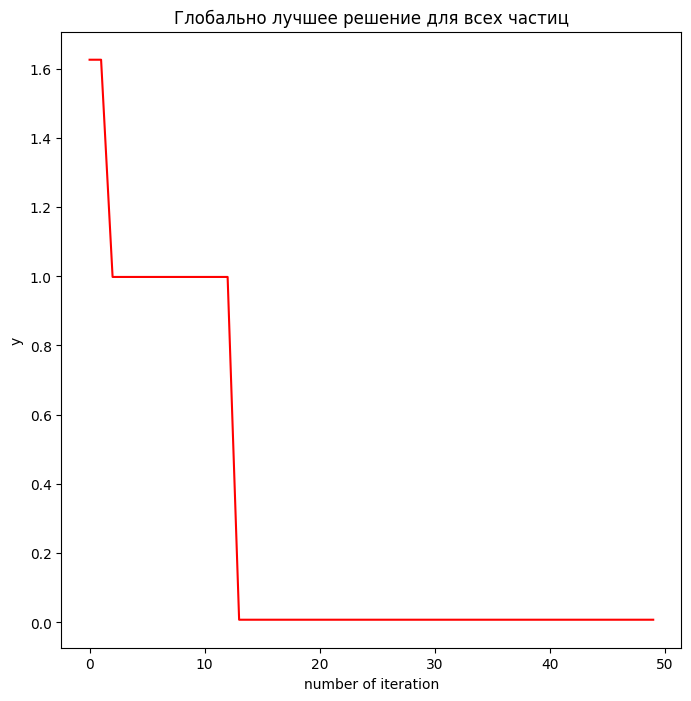

In [37]:
print(list_of_best_coord, "\n", list_of_best_solution)

plt.plot(np.arange(list_of_best_solution.size), list_of_best_solution, c = 'r')
plt.xlabel("number of iteration")
plt.ylabel("y")
plt.title("Глобально лучшее решение для всех частиц")
plt.show()

# Тестирование функций для оптимизации

global_best: 0.017823708648595726 coordinates: [-0.00947983]
global_best: 0.008096227084164909 coordinates: [-0.00638864]
global_best: 0.038077480567855204 coordinates: [-0.01385825]
global_best: 0.0015800652495912004 coordinates: [0.00282216]
global_best: 0.2495615328671903 coordinates: [-0.03554061]
global_best: 0.02349111436515905 coordinates: [0.01088363]
global_best: 0.029387650786517838 coordinates: [-0.01217378]
global_best: 0.0008209306711588482 coordinates: [0.0020342]
global_best: 0.0025675146344763533 coordinates: [0.00359752]
global_best: 0.019648361368629352 coordinates: [0.0099534]


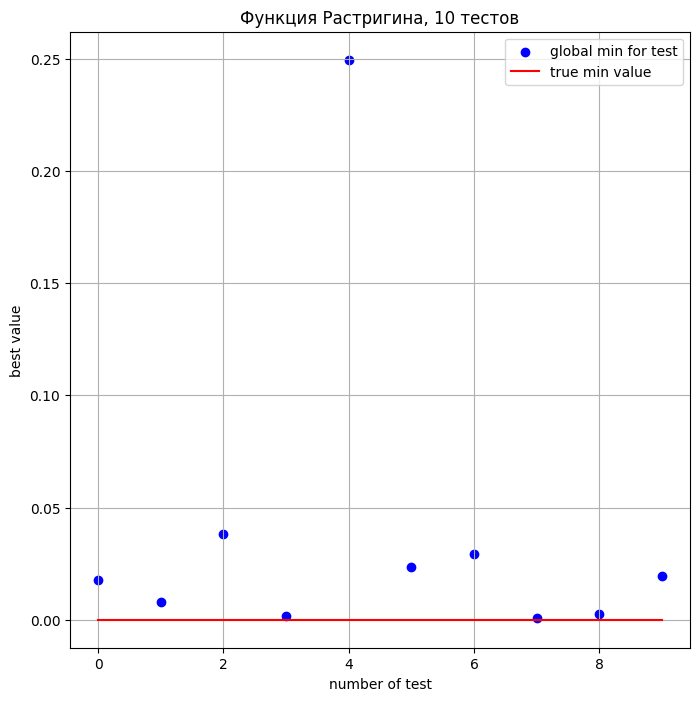

In [20]:
def draw(f, title: str):

    for i in range(10):
        list_of_best_x, list_of_best_y = main(1.154, 2, f)[1]

        y = list_of_best_y[len(list_of_best_y) - 1]

        if i == 0:
            plt.scatter(i, y, c = 'b', label = 'global min for test')
            plt.plot(np.arange(10), np.zeros(10), c = 'r', label = 'true min value')
            plt.legend()
            plt.xlabel("number of test")
            plt.ylabel("best value")
        else:
            plt.scatter(i, y, c = 'b')

    plt.title(title)
    plt.show()

draw(rastrigin, "Функция Растригина, 10 тестов")

global_best: 0.0001890661731162037 coordinates: [0.01375013]
global_best: 1.4604538199371255e-05 coordinates: [-0.00382159]
global_best: 2.0336447146891464e-05 coordinates: [-0.0045096]
global_best: 2.7744627792042565e-05 coordinates: [0.00526732]
global_best: 0.0002766627754575127 coordinates: [0.01663318]
global_best: 3.6542536320627116e-06 coordinates: [-0.00191161]
global_best: 0.0001511722340372894 coordinates: [-0.01229521]
global_best: 0.0006433309890775194 coordinates: [-0.02536397]
global_best: 0.0007888425138195271 coordinates: [-0.02808634]
global_best: 0.0035744472629184705 coordinates: [0.05978668]


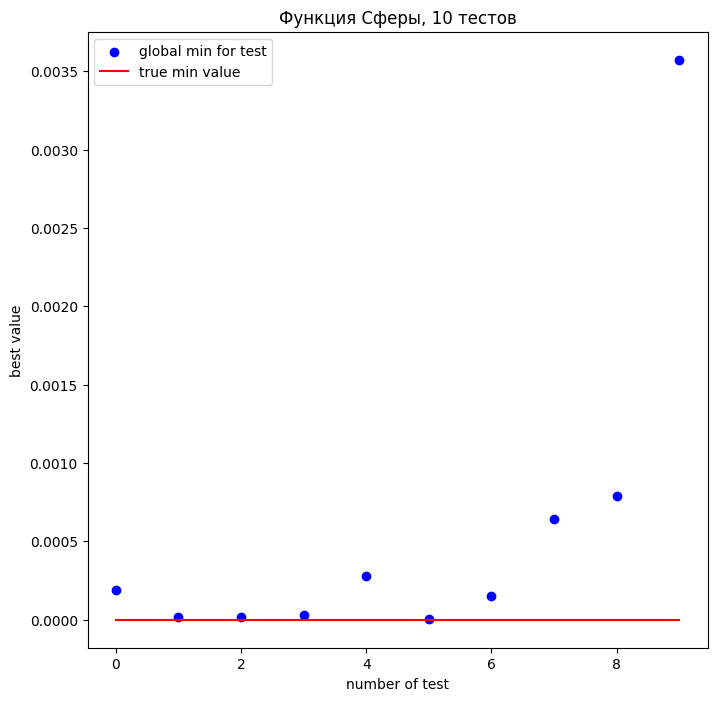

In [39]:
draw(sphere, "Функция Сферы, 10 тестов")

global_best: 0.0 coordinates: [-3.86590235]
global_best: 0.0 coordinates: [-0.49035348]
global_best: 0.0 coordinates: [-4.44519618]
global_best: 0.0 coordinates: [2.29108398]
global_best: 0.0 coordinates: [-2.06656075]
global_best: 0.0 coordinates: [0.98713772]
global_best: 0.0 coordinates: [2.74266925]
global_best: 0.0 coordinates: [0.71275346]
global_best: 0.0 coordinates: [5.11634448]
global_best: 0.0 coordinates: [0.05931903]


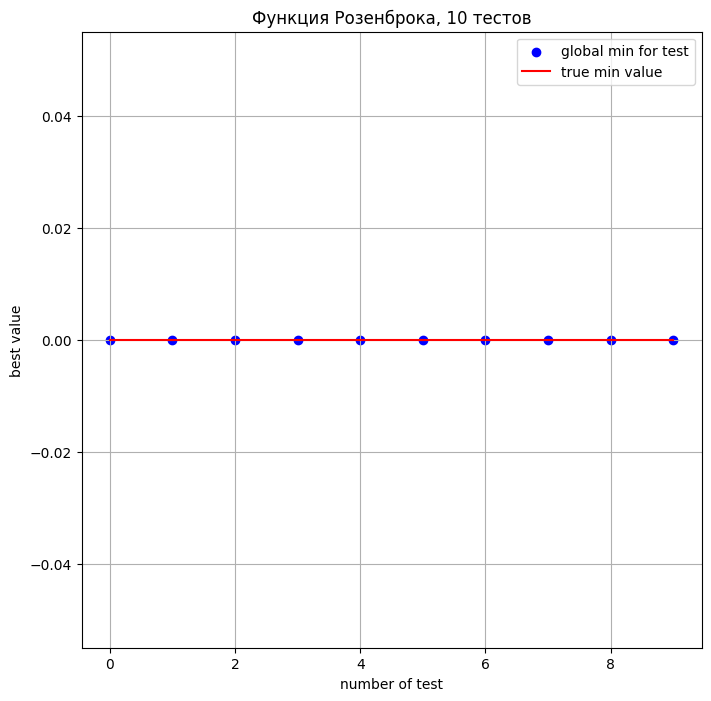

In [22]:
draw(rozenbroke, "Функция Розенброка, 10 тестов")

# Реализация метода роя частиц на C. Сравнение двух реализаций

In [23]:
import ctypes
import os

class Result(ctypes.Structure):
    _fields_ = [
        ("best_solution", ctypes.POINTER(ctypes.c_float)),
        ("best_y", ctypes.c_float),
        ("time_spent", ctypes.c_double)
    ]

def c(file, name, types, result):
    path = os.path.abspath(file)
    module = ctypes.cdll.LoadLibrary(path)
    func = module[name]
    func.argtypes = types
    func.restype = result
    return func


test_rastrigin = c("libcode.dll", "test_rastrigin", (ctypes.c_int, ctypes.c_float), Result)
test_sphere = c("libcode.dll", "test_sphere", (ctypes.c_int, ctypes.c_float), Result)
test_rozenbroke = c("libcode.dll", "test_rozenbroke", (ctypes.c_int, ctypes.c_float), Result)

dimension = 2
v_max = 1.134

result = test_rastrigin(dimension, v_max)
print("best:", result.best_y)
print("Time is", result.time_spent)

best_solution = [result.best_solution[i] for i in range(dimension - 1)]
print("Coordinates:", best_solution)



result = test_sphere(dimension, v_max)
print("best:", result.best_y)
print("Time is", result.time_spent)

best_solution = [result.best_solution[i] for i in range(dimension - 1)]
print("Coordinates:", best_solution)



result = test_rozenbroke(dimension, v_max)
print("best:", result.best_y)
print("Time is", result.time_spent)

best_solution = [result.best_solution[i] for i in range(dimension - 1)]
print("Coordinates:", best_solution)

best: 0.0
Time is 0.013
Coordinates: [0.0]
best: 0.0
Time is 0.024
Coordinates: [0.0]
best: 0.0
Time is 0.016
Coordinates: [0.0]


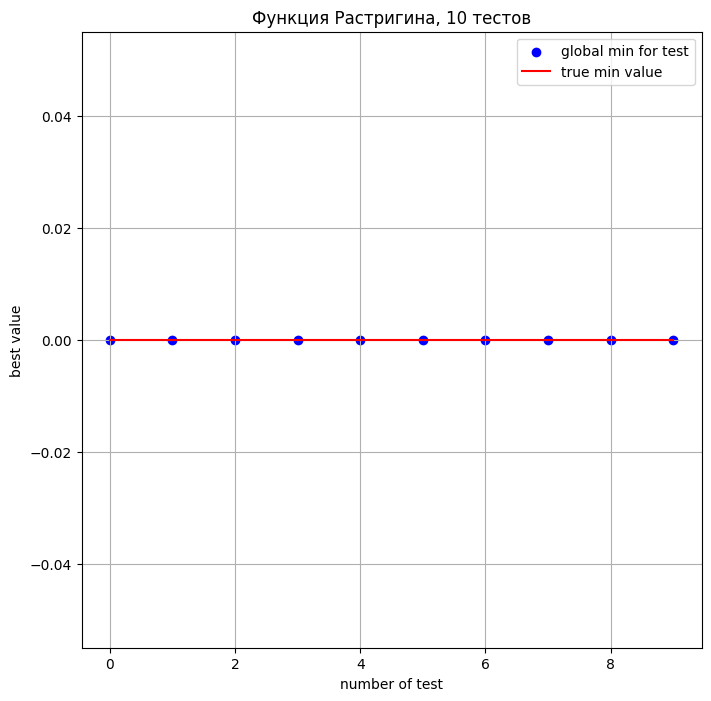

In [24]:
def draw_c(f, title: str):
    dimension = 2
    v_max = 1.134

    for i in range(10):
        y = f(dimension, v_max).best_y

        if i == 0:
            plt.scatter(i, y, c = 'b', label = 'global min for test')
            plt.plot(np.arange(10), np.zeros(10), c = 'r', label = 'true min value')
            plt.legend()
            plt.xlabel("number of test")
            plt.ylabel("best value")
        else:
            plt.scatter(i, y, c = 'b')

    plt.title(title)
    plt.show()

draw_c(test_rastrigin, "Функция Растригина, 10 тестов")

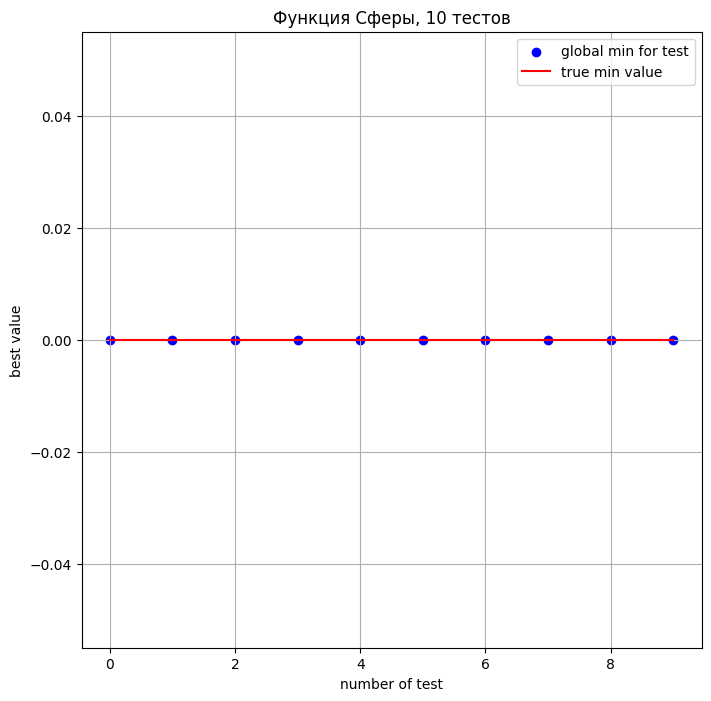

In [25]:
draw_c(test_sphere, "Функция Сферы, 10 тестов")

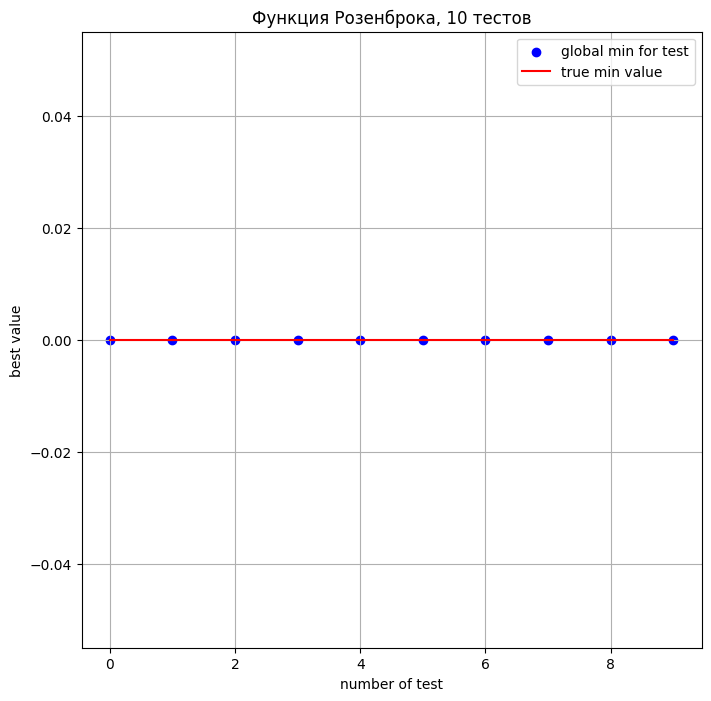

In [26]:
draw_c(test_rozenbroke, "Функция Розенброка, 10 тестов")

<h3>Сравнение реализаций по скорости выполнения</h3>

In [27]:
@njit
def running_on_time(v_max: float, dimension: int, f):
    px_list: np.ndarray
    py_list: np.ndarray
    best_solution: np.ndarray
    best_coord: np.ndarray

    r1 = np.random.rand(dimension - 1)
    r2 = np.random.rand(dimension - 1)
    weight = 3.4
    p_global_best = 1000.0
    p_best_coordinates = np.zeros(dimension - 1)

    for j in range(50):
        coordinates = np.random.uniform(-5.12, 5.12, dimension - 1)
        c1 = random()
        c2 = random()
        p_coordinates_now = np.copy(coordinates)
        p_coordinates = np.copy(coordinates)
        p = f(coordinates)
        array_of_speed = np.zeros((400, dimension - 1))

        if p_global_best > p:
            p_best_coordinates = p_coordinates
            p_global_best = p

        for k in range(dimension - 1):
            array_of_speed[0][k] = uniform(-1 * v_max, v_max)

        for i in range(1, len(array_of_speed)):
            array_of_speed[i] = array_of_speed[i - 1] * weight + \
                                c1 * r1 * (p_best_coordinates - p_coordinates_now) + \
                                c2 * r2 * (p_best_coordinates - p_coordinates_now)

            for k in range(dimension - 1):
                if array_of_speed[i][k] > 0:
                    array_of_speed[i][k] = min(array_of_speed[i][k], v_max)
                else:
                    array_of_speed[i][k] = max(array_of_speed[i][k], v_max)

            p_coordinates_now = p_coordinates_now + array_of_speed[i]

            if p > f(p_coordinates_now):
                p = f(p_coordinates_now)
                p_coordinates = p_coordinates_now

        if p_global_best > p:
            p_best_coordinates = p_coordinates
            p_global_best = p

    return p_best_coordinates, p_global_best

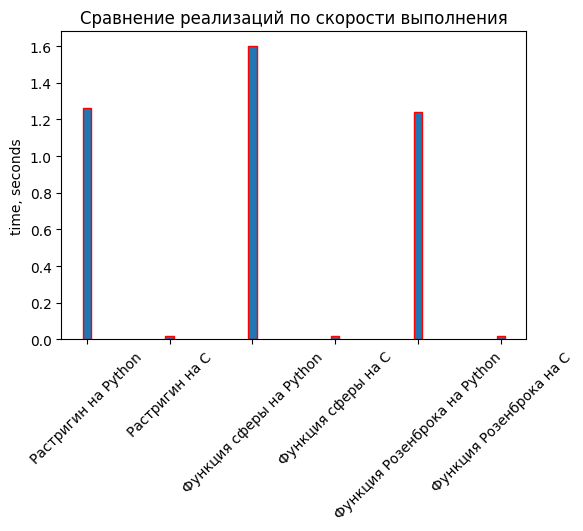

In [28]:
def time_remember(f):
    start = time.time()
    running_on_time(v_max, dimension, f)
    end = time.time() - start
    return end

dimension = 2
v_max = 1.134

time_rastrigin_on_c = test_rozenbroke(dimension, v_max).time_spent
time_sphere_on_c = test_sphere(dimension, v_max).time_spent
time_rozenbroke_on_c = test_rozenbroke(dimension, v_max).time_spent

time_rastrigin_on_python = time_remember(rastrigin)
time_sphere_on_python = time_remember(sphere)
time_rozenbroke_on_python = time_remember(rozenbroke)

plt.rcParams['axes.grid'] = False
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

list_to_draw = [time_rastrigin_on_python, time_rastrigin_on_c,
                time_sphere_on_python, time_sphere_on_c,
                time_rozenbroke_on_python, time_rozenbroke_on_c]
list_of_title = ['Растригин на Python', 'Растригин на C',
                 'Функция сферы на Python', 'Функция сферы на C',
                 'Функция Розенброка на Python', 'Функция Розенброка на С']

ax.bar(list_of_title, list_to_draw, width = 0.1, edgecolor='r')

plt.ylabel("time, seconds")
plt.title("Сравнение реализаций по скорости выполнения")
plt.xticks(rotation=45)
plt.show()